# Avian Flu Data

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
from cmdstanpy import CmdStanModel, cmdstan_path
import arviz as az
import nest_asyncio
import seaborn as sns
nest_asyncio.apply()

num_timepoints = 21 # number of days for incidence data
num_categories = 2

trace_names = ['0-19 years old', '20+ years old']

/Users/ioaros/opt/anaconda3/envs/testbranchpro2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parametrisation of the renewal model

In [2]:
# Build the serial interval w_s
ws_mean = 1.9
coeff_var = 0.47
ws_std = coeff_var * ws_mean

theta = ws_std**2 / ws_mean
k = ws_mean / theta
w_dist = scipy.stats.gamma(k, scale=theta)
disc_w = w_dist.pdf(np.arange(30))

serial_interval = disc_w

# Select a range of different contact matrices

path = os.path.join('../../data_library/polymod/final_contact_matrices/', 'BASE_Japan.csv')
contact_matrix = pd.read_csv(path, header=None).to_numpy()

# Choose unique transmissibilityt vector for ease so
# effective contact matrix = contact matrix
transmissibility = [1, 1]

# Number of cases
desagg_cases = np.array(
    [[5, 0], [5, 0], [7, 0], [6, 1], 
     [7, 3], [15, 1], [41, 4], [54, 5],
     [54, 10], [37, 11], [29, 5], [13, 7], 
     [8, 6], [4, 1], [5, 0], [1, 0],
     [2, 1], [2, 4], [2, 0], [2, 0], [3, 0]]
)

agg_cases = np.sum(desagg_cases, axis=1)

## Plot the Incidence Data

In [3]:
# Plot (bar chart cases each day)
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Bar(
        x=np.arange(num_timepoints),
        y=desagg_cases[:, 0],
        name='Incidences 0-19'
    )
)

fig.add_trace(
    go.Bar(
        x=np.arange(num_timepoints),
        y=desagg_cases[:, 1],
        name='Incidences 20+'
    )
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='New infections',
    width=900, 
    height=600,
    plot_bgcolor='white',
    font=dict(
            size=16),
    xaxis=dict(
        linecolor='black'),
    yaxis=dict(
        linecolor='black'),
    legend=dict(
            yanchor="bottom",
            y=0.8,
            xanchor="right",
            x=0.95,
            bordercolor="Black",
            borderwidth=1
        )
)

fig.write_image('images/Incidence Avian Flu .pdf')

fig.show()

## R_t inference using STAN

In [4]:
# Same inference, but using the PoissonBranchProPosterior
tau = 6
R_t_start = tau+1
a = 1
b = 1/5
sigma = 1.5

In [5]:
# Transform our incidence data into pandas dataframes
multicat_inc_data_matrix = {'Time': np.arange(num_timepoints)}

for _ in range(num_categories):
    multicat_inc_data_matrix['Incidence Number Cat {}'.format(_+1)] = \
        desagg_cases[:, _]

multicat_inc_data = pd.DataFrame(multicat_inc_data_matrix)

inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': agg_cases
    }
)

eff_contact_matrix = np.matmul(contact_matrix, np.diag(transmissibility))
spec_radius = np.max(np.absolute(np.linalg.eigvals(eff_contact_matrix)))

# Correction for reproduction number per category
correc_i = np.multiply(np.sum(contact_matrix, axis=0), transmissibility) / spec_radius

L1 = len(np.arange(R_t_start, num_timepoints))

## Multiple group model

In [9]:
approx_multicat_model = CmdStanModel(stan_file=os.path.join(
        '../../stan_models/approx_multicat_specC.stan'))

approx_multicat_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'n': num_categories,
    'C': contact_matrix,
    'specC': spec_radius,
    'transm': transmissibility,
    'I': desagg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

15:08:54 - cmdstanpy - INFO - compiling stan file /var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/tmpnw7op__x/tmpn_a7rubj.stan to exe file /Users/ioaros/Desktop/Software Project/branchpro/branchpro/stan_models/approx_multicat_specC
15:09:09 - cmdstanpy - INFO - compiled model executable: /Users/ioaros/Desktop/Software Project/branchpro/branchpro/stan_models/approx_multicat_specC
/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_29564/3354186671.py:11: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [10]:
fit = approx_multicat_model.sample(data=approx_multicat_data, seed=10, chains=3, iter_sampling=1000)

samples = az.from_cmdstanpy(fit)

az.summary(samples)

15:09:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status
chain 1 |▍         | 00:00 Status
chain 1 |▉         | 00:02 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:04 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:05 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:06 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:08 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:09 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:10 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:11 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:13 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:15 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:17 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:18 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:20 Iteration: 1200 / 2000 [ 60%]  (Sampling)



15:09:40 - cmdstanpy - INFO - CmdStan done processing.
15:09:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'approx_multicat_specC.stan', line 56, column 8 to column 28)
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'approx_multicat_specC.stan', line 56, column 8 to column 28)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'approx_multicat_specC.stan', line 56, column 8 to column 28)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'approx_multicat_specC.stan', line 56, column 8 to column 28)
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'approx_multicat_specC.stan', line 56, column 8 to column 28)
Consider re-running with show_console=True if the above output is unclear!


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
R[0],3.339,0.280,2.834,3.884,0.003,0.002,6810.0,2183.0,1.0
R[1],2.869,0.189,2.527,3.239,0.002,0.002,6869.0,2230.0,1.0
R[2],2.061,0.130,1.807,2.291,0.002,0.001,6056.0,1817.0,1.0
R[3],1.528,0.092,1.351,1.698,0.001,0.001,6435.0,2109.0,1.0
R[4],1.205,0.074,1.070,1.338,0.001,0.001,7324.0,1992.0,1.0
R[5],1.011,0.060,0.904,1.126,0.001,0.000,7816.0,2314.0,1.0
R[6],0.792,0.051,0.698,0.886,0.001,0.000,6890.0,2241.0,1.0
R[7],0.599,0.043,0.518,0.680,0.000,0.000,7474.0,2004.0,1.0
R[8],0.421,0.036,0.353,0.485,0.000,0.000,5656.0,2173.0,1.0
R[9],0.318,0.035,0.249,0.383,0.000,0.000,5300.0,1829.0,1.0


array([[<Axes: title={'center': 'R\n0'}>,
        <Axes: title={'center': 'R\n0'}>],
       [<Axes: title={'center': 'R\n1'}>,
        <Axes: title={'center': 'R\n1'}>],
       [<Axes: title={'center': 'R\n2'}>,
        <Axes: title={'center': 'R\n2'}>],
       [<Axes: title={'center': 'R\n3'}>,
        <Axes: title={'center': 'R\n3'}>],
       [<Axes: title={'center': 'R\n4'}>,
        <Axes: title={'center': 'R\n4'}>],
       [<Axes: title={'center': 'R\n5'}>,
        <Axes: title={'center': 'R\n5'}>],
       [<Axes: title={'center': 'R\n6'}>,
        <Axes: title={'center': 'R\n6'}>],
       [<Axes: title={'center': 'R\n7'}>,
        <Axes: title={'center': 'R\n7'}>],
       [<Axes: title={'center': 'R\n8'}>,
        <Axes: title={'center': 'R\n8'}>],
       [<Axes: title={'center': 'R\n9'}>,
        <Axes: title={'center': 'R\n9'}>],
       [<Axes: title={'center': 'R\n10'}>,
        <Axes: title={'center': 'R\n10'}>],
       [<Axes: title={'center': 'R\n11'}>,
        <Axes: title

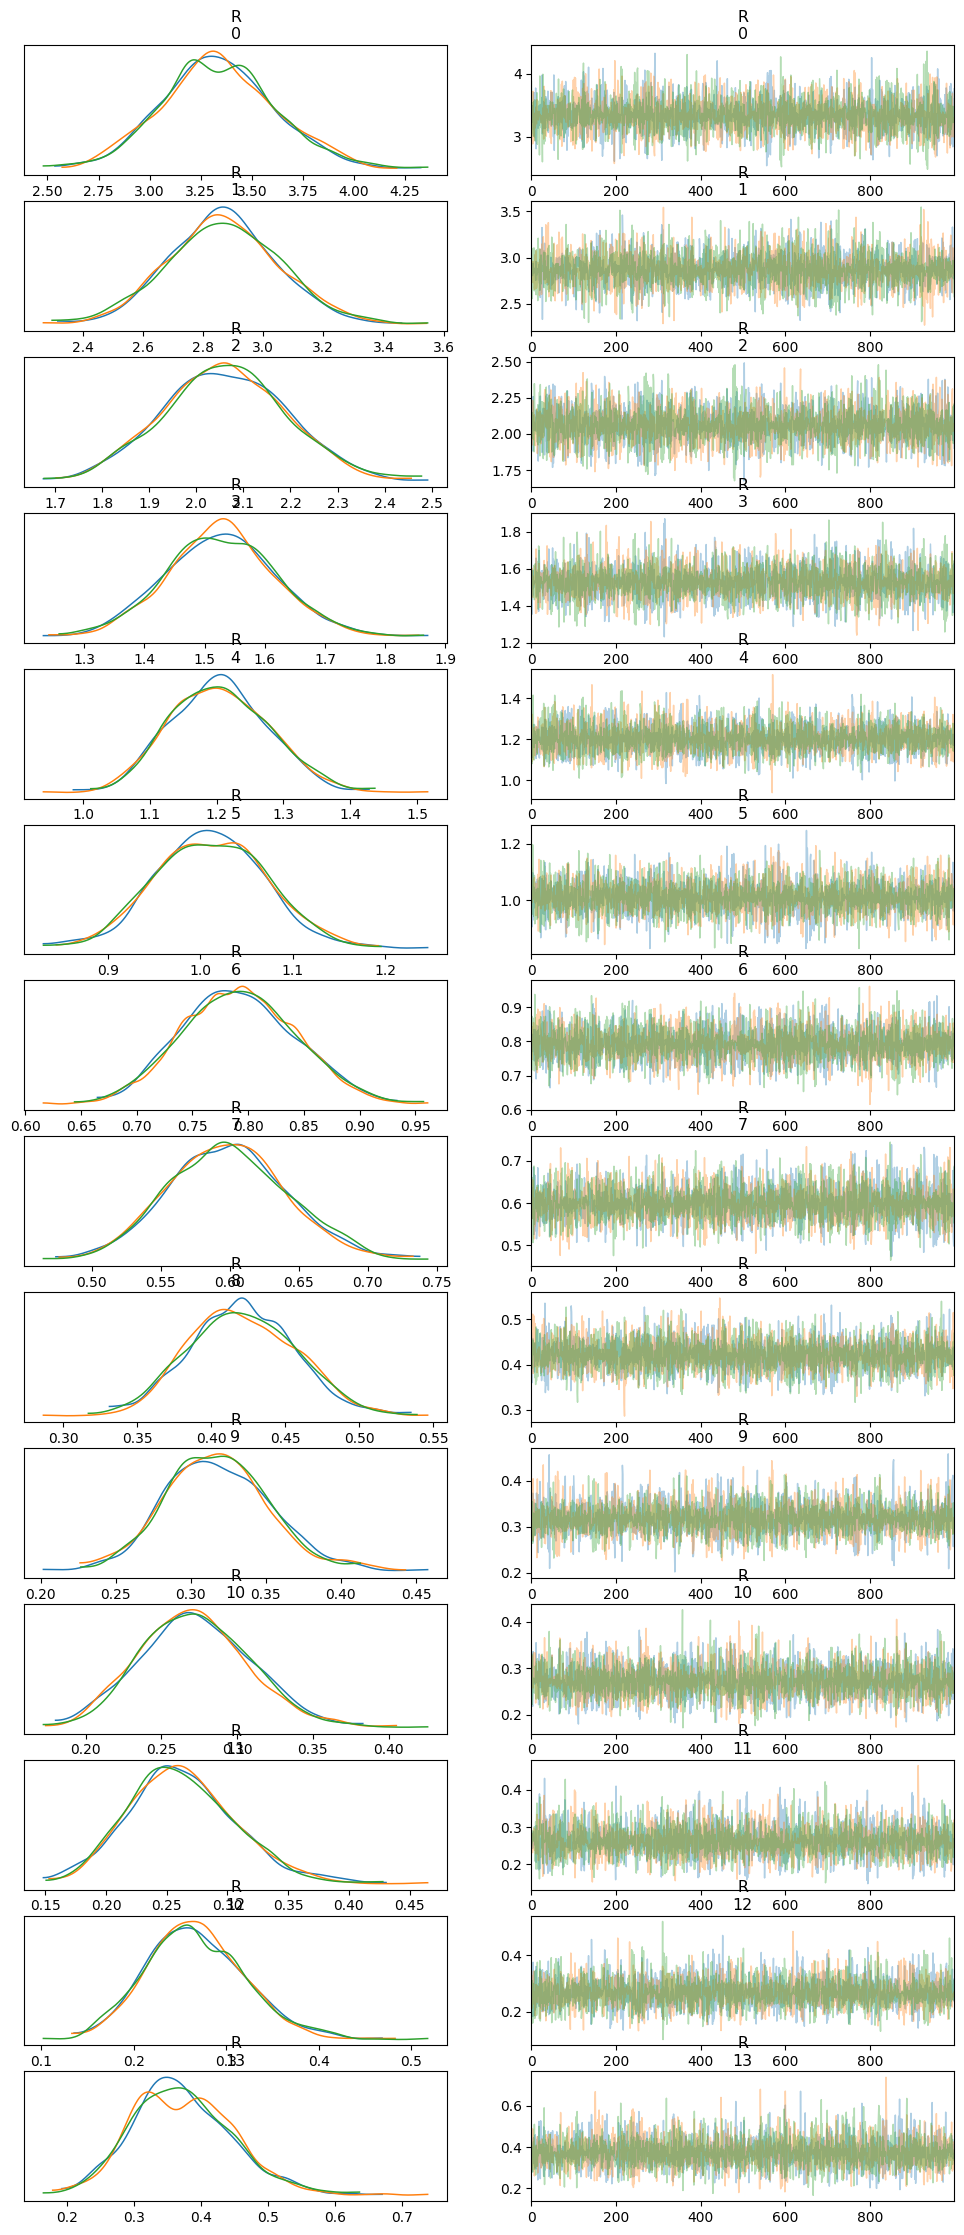

In [11]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

In [12]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit.draws()[500:, :, 7:]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, 0, :],
    chain_samples[:, 1, :],
    chain_samples[:, 2, :]), axis=0)

thinning = max(1, int(n_sample * n_chains / 500))
approx_multicat_intervals = []

for j in range(num_categories):
    approx_multicat_intervals.append(pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'Mean': np.mean(correc_i[j] * extended_samples[::thinning, :], axis=0),
        'Lower bound CI': np.quantile(correc_i[j] * extended_samples[::thinning, :], 0.025, axis=0),
        'Upper bound CI': np.quantile(correc_i[j] * extended_samples[::thinning, :], 0.975, axis=0),
        'Central Probability': L1 * [0.95]
    }))

overall_approx_multicat_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[::thinning, :], axis=0),
    'Lower bound CI': np.quantile(extended_samples[::thinning, :], 0.025, axis=0),
    'Upper bound CI': np.quantile(extended_samples[::thinning, :], 0.975, axis=0),
    'Central Probability': L1 * [0.95]
})

## One group model

In [13]:
poisson_model = CmdStanModel(stan_file=os.path.join(
        '../../stan_models/poisson_one.stan'))

poisson_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'I': agg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_29564/3414372969.py:7: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [14]:
fit = poisson_model.sample(
    data=poisson_data, seed=10, chains=3, iter_sampling=1000)

samples = az.from_cmdstanpy(fit)

az.summary(samples)

15:09:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status

chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |████████▋ | 00:02 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                       
chain 3 |██████████| 00:02 Sampling completed                       


15:09:46 - cmdstanpy - INFO - CmdStan done processing.
15:09:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'poisson_one.stan', line 45, column 8 to column 28)
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'poisson_one.stan', line 45, column 8 to column 28)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'poisson_one.stan', line 45, column 8 to column 28)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'poisson_one.stan', line 45, column 8 to column 28)
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'poisson_one.stan', line 45, column 8 to column 28)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'poisson_one.stan', line 45, column 8 to column 28)
Consider re-running with show_console=True if the above output is unclear!


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
R[0],3.827,0.309,3.238,4.404,0.004,0.003,7157.0,2375.0,1.00
R[1],3.287,0.236,2.822,3.713,0.003,0.002,8442.0,1761.0,1.00
R[2],2.368,0.149,2.099,2.648,0.002,0.001,7043.0,1985.0,1.00
R[3],1.751,0.108,1.556,1.957,0.001,0.001,6986.0,2195.0,1.00
R[4],1.377,0.081,1.227,1.527,0.001,0.001,7469.0,2539.0,1.00
R[5],1.151,0.066,1.022,1.272,0.001,0.000,9259.0,2185.0,1.00
R[6],0.900,0.058,0.798,1.007,0.001,0.000,9257.0,2408.0,1.00
R[7],0.678,0.048,0.589,0.762,0.001,0.000,7487.0,2633.0,1.00
R[8],0.476,0.043,0.399,0.556,0.001,0.000,7006.0,1862.0,1.00
R[9],0.358,0.038,0.291,0.431,0.000,0.000,6625.0,2022.0,1.01


array([[<Axes: title={'center': 'R\n0'}>,
        <Axes: title={'center': 'R\n0'}>],
       [<Axes: title={'center': 'R\n1'}>,
        <Axes: title={'center': 'R\n1'}>],
       [<Axes: title={'center': 'R\n2'}>,
        <Axes: title={'center': 'R\n2'}>],
       [<Axes: title={'center': 'R\n3'}>,
        <Axes: title={'center': 'R\n3'}>],
       [<Axes: title={'center': 'R\n4'}>,
        <Axes: title={'center': 'R\n4'}>],
       [<Axes: title={'center': 'R\n5'}>,
        <Axes: title={'center': 'R\n5'}>],
       [<Axes: title={'center': 'R\n6'}>,
        <Axes: title={'center': 'R\n6'}>],
       [<Axes: title={'center': 'R\n7'}>,
        <Axes: title={'center': 'R\n7'}>],
       [<Axes: title={'center': 'R\n8'}>,
        <Axes: title={'center': 'R\n8'}>],
       [<Axes: title={'center': 'R\n9'}>,
        <Axes: title={'center': 'R\n9'}>],
       [<Axes: title={'center': 'R\n10'}>,
        <Axes: title={'center': 'R\n10'}>],
       [<Axes: title={'center': 'R\n11'}>,
        <Axes: title

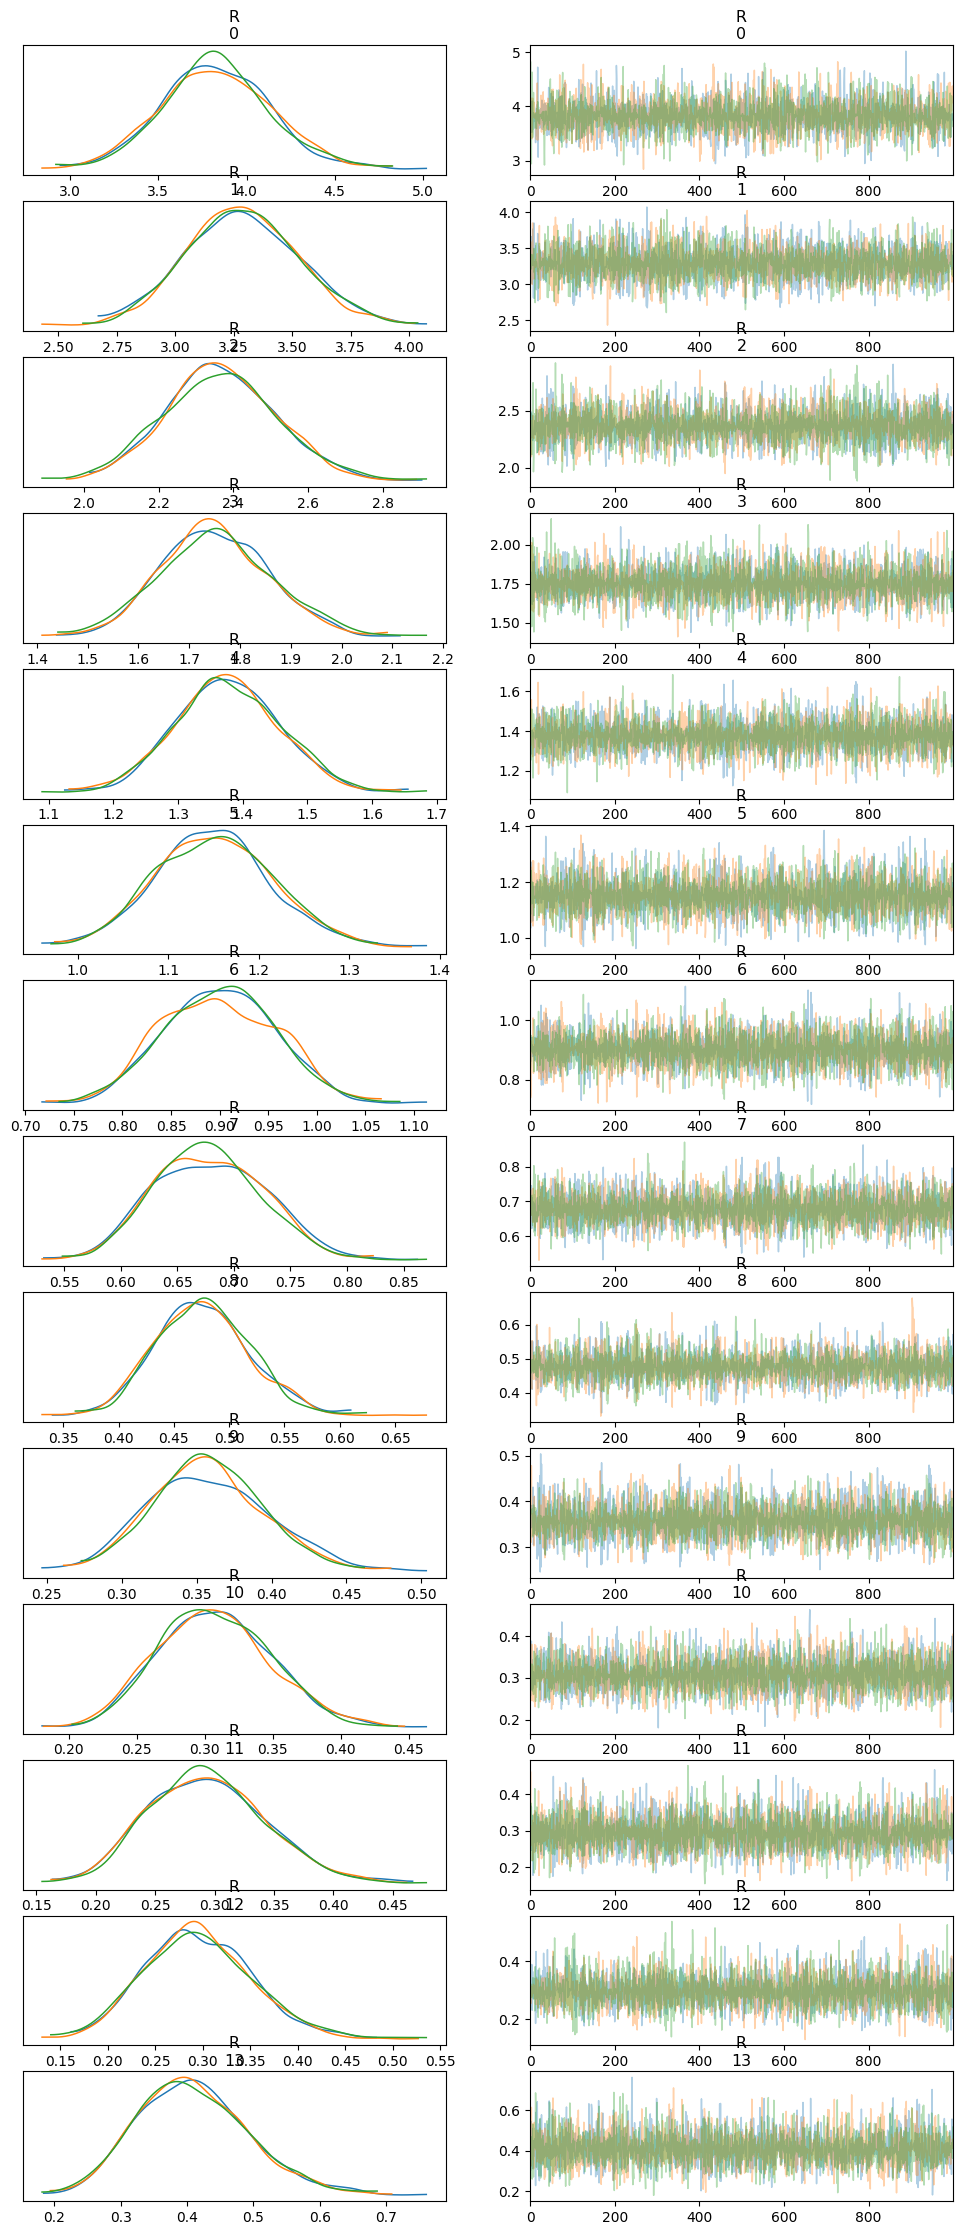

In [15]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

In [16]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit.draws()[500:, :, 7:]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, 0, :],
    chain_samples[:, 1, :],
    chain_samples[:, 2, :]), axis=0)

thinning = max(1, int(n_sample * n_chains / 500))

pois_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[::thinning, :], axis=0),
    'Lower bound CI': np.quantile(extended_samples[::thinning, :], 0.025, axis=0),
    'Upper bound CI': np.quantile(extended_samples[::thinning, :], 0.975, axis=0),
    'Central Probability': L1 * [0.95]
})

In [17]:
colour_names = ['#EC9F0A', '#D41159', '#1A85FF']

fig = ReproductionNumberPlot()

for j in range(num_categories):
    fig.add_interval_rt(approx_multicat_intervals[j], colour=colour_names[0], shape=[None, 'dash'][j], model_type='Multiple Group Model, {}'.format(trace_names[j]))
fig.add_interval_rt(overall_approx_multicat_intervals, colour=colour_names[1], model_type='Multiple Group Model, overall')
fig.add_interval_rt(pois_intervals, colour=colour_names[2], model_type='One Group Model')
    
fig.update_labels(time_label='Time (days)', r_label='Reproduction number R<sub>t</sub>')

fig.figure.data = [fig.figure.data[0], fig.figure.data[2], fig.figure.data[4], fig.figure.data[6]]

fig.figure.add_hline(
    y=1, line_dash='dot',
    annotation_text='R<sub>t</sub>=1', fillcolor='black',
    annotation_position='top right')

fig.figure.update_layout(
    width=900, 
    height=600,
    plot_bgcolor='white',
    font=dict(
            size=16),
    xaxis=dict(
        linecolor='black'),
    yaxis=dict(
        linecolor='black'),
    legend=dict(
            orientation="h",
            yanchor="bottom",
            y=0.8,
            xanchor="right",
            x=1.05,
            bordercolor="Black",
            borderwidth=1
        )
)

fig.figure.write_image('images/Avian Flu.pdf')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.

